In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.utils import isWeekend

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
tasks = pd.read_csv('data/task_report_30_4.csv')
task_detail = pd.read_csv('data/task_30.csv')
projects = pd.read_csv('data/project_report_30_4.csv')
project_detail = pd.read_csv('data/project_30.csv')

In [6]:
projects['Progress'] = projects['CompletedTask']/projects['TotalTask']*100

projects['Date'] = pd.to_datetime(projects['Date'])
projects['StartDate'] = pd.to_datetime(projects['StartDate'])
projects['EndDate'] = pd.to_datetime(projects['EndDate'])
projects['ActualStartDate'] = pd.to_datetime(projects['ActualStartDate'])
projects['ActualEndDate'] = pd.to_datetime(projects['ActualEndDate'])

projects['Weekend'] = projects['Date'].apply(lambda x: isWeekend(x)).astype(int)
projects['DayCount'] = (projects['Date']-projects['StartDate']).dt.days 
projects['Delay'] = (projects['ActualEndDate'] - projects['EndDate']).dt.days

In [7]:
test_idx = projects.loc[tasks['ProjectID'].isin([28,29,30])].index.tolist()

In [8]:
projects_df =  projects.drop(columns=['Date','ProjectID','StartDate','EndDate','ActualStartDate','ActualEndDate'])
projects_df = projects_df.astype(float)

In [9]:
columns = projects_df.columns.tolist()
target = 'Delay'
features = columns.copy()
features.remove(target)

<Axes: >

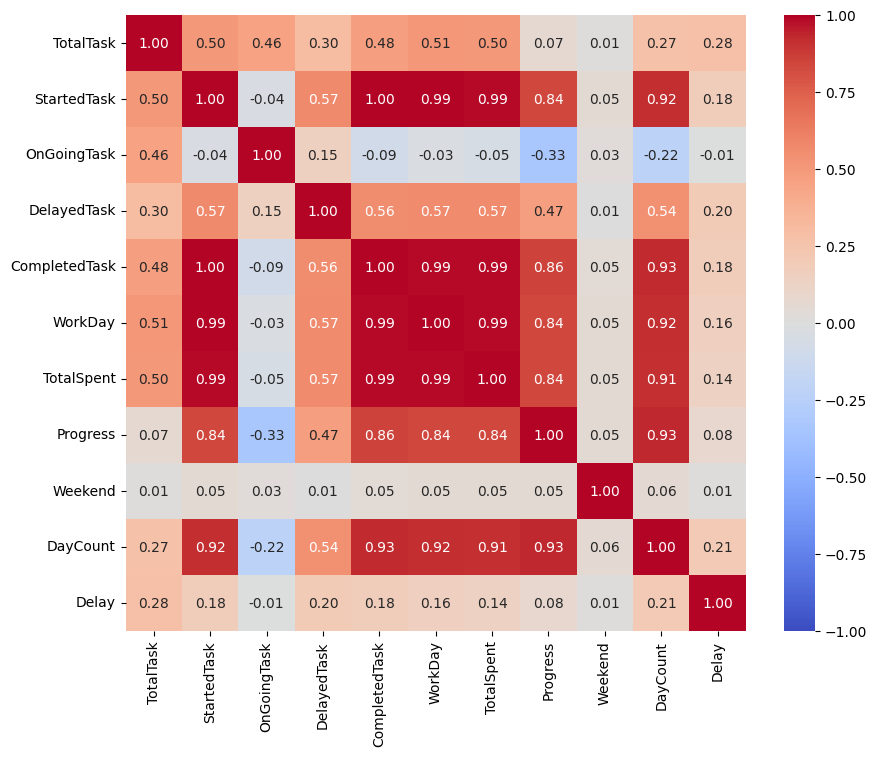

In [10]:
plt.figure(figsize=(10, 8))
sns.heatmap(projects_df.corr(), vmin=-1, vmax=1, annot=True, fmt=".2f",cmap='coolwarm')

<Axes: >

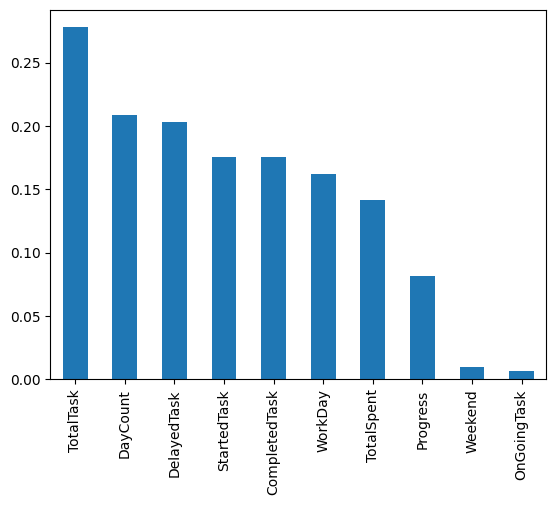

In [11]:
projects_df.corr()[target].abs().sort_values(ascending=False).iloc[1:].plot(kind='bar')

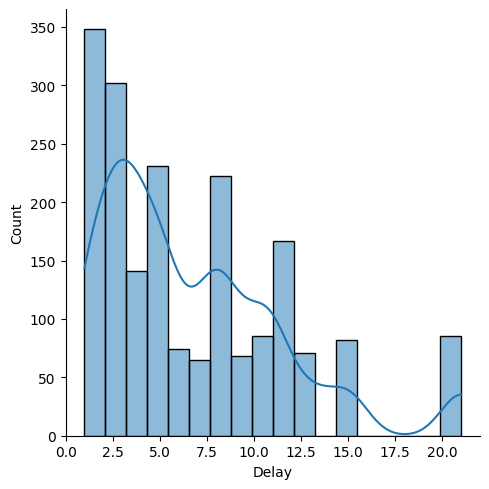

In [14]:
sns.displot(projects_df['Delay'], kde=True)

In [15]:
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, TheilSenRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor, BaggingRegressor, VotingRegressor, StackingRegressor

In [16]:
X = projects_df.copy()
y = X.pop(target)

X_train = X[~X.index.isin(test_idx)]
y_train = y[~y.index.isin(test_idx)]
X_test = X[X.index.isin(test_idx)]
y_test = y[y.index.isin(test_idx)]

# Creating and training the decision tree regression model
model = DecisionTreeRegressor(max_depth=5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_pred)
print("Train MAE :", mae_train, " | Test MAE : ", mae_test)

Train MAE : 1.3947673568783259  | Test MAE :  1.678734044685054


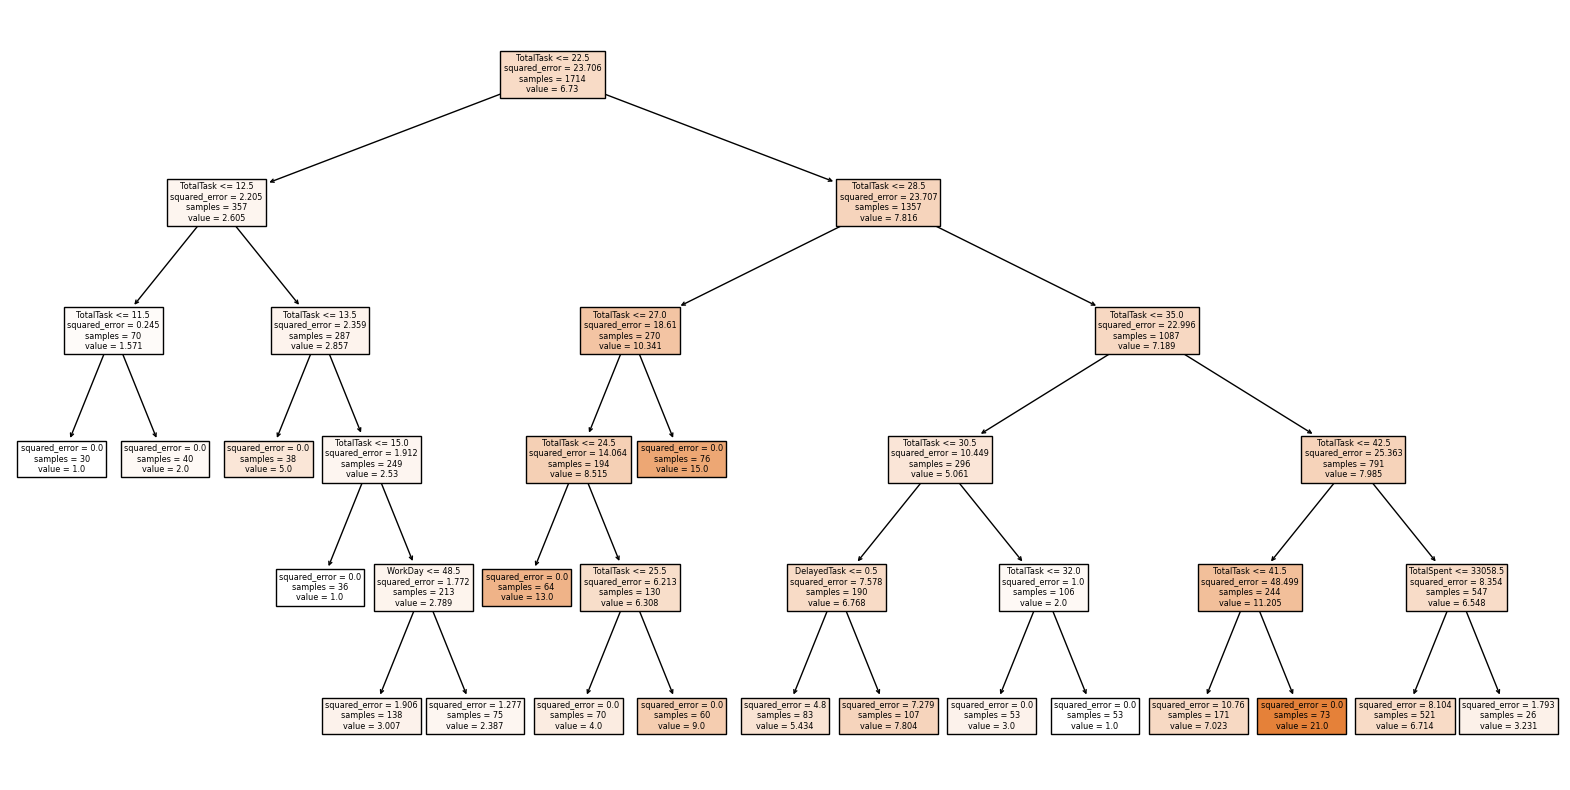

In [17]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Plot the decision tree
plt.figure(figsize=(20,10))
plot_tree(model, filled=True, feature_names=X.columns)
plt.show()

In [18]:
models = {
        "Linear Regression": LinearRegression(),
        "Ridge Regression": Ridge(),
        "Lasso Regression": Lasso(),
        "ElasticNet Regression": ElasticNet(),
        "SVR": SVR(),
        "Decision Tree": DecisionTreeRegressor(max_depth=5),
        "Random Forest": RandomForestRegressor(max_depth=5),
        "Extra Trees": ExtraTreesRegressor(max_depth=5),
        "Gradient Boosting": GradientBoostingRegressor(),
        "Bagging Regression": BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=5)),
        "AdaBoost Regression": AdaBoostRegressor(),
        "Bayesian Ridge Regression": BayesianRidge(),
        "Theil-Sen Regression": TheilSenRegressor()
    }

def evaluate_regression_models(X_train, y_train, X_test, y_test, models):    
    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        mae_train = mean_absolute_error(y_train, y_train_pred)
        mae_test = mean_absolute_error(y_test, y_test_pred)
        results.append({"Model": name, "Train MAE": mae_train, "Test MAE": mae_test})
    
    return pd.DataFrame(results)

results_df = evaluate_regression_models(X_train, y_train, X_test, y_test, models)
results_df.sort_values(by='Test MAE', inplace=True)

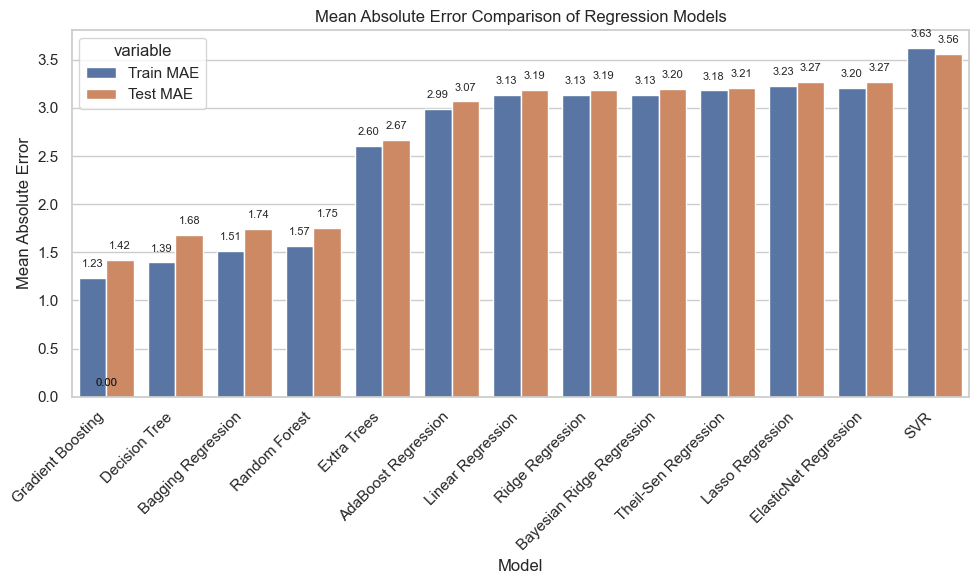

In [19]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=results_df.melt(id_vars="Model"), x="Model", y="value", hue="variable")
ax.set_title('Mean Absolute Error Comparison of Regression Models')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlabel('Model')
plt.xticks(rotation=45, ha='right')

# Adding value labels above each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points',
                fontsize=8)  # Adjust font size here

plt.tight_layout()
plt.show()

In [20]:
models_list = list(models.values())
voting_ensemble = VotingRegressor(estimators=[(name, model) for name, model in models.items()])
voting_ensemble.fit(X_train, y_train)

# Evaluate the voting ensemble
y_train_pred = voting_ensemble.predict(X_train)
y_test_pred = voting_ensemble.predict(X_test)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print("Voting Ensemble Train MAE:", mae_train)
print("Voting Ensemble Test MAE:", mae_test)

Voting Ensemble Train MAE: 2.4652223346550213
Voting Ensemble Test MAE: 2.565266151088654


In [23]:
base_models = [(name, model) for name, model in models.items() if name != "Gradient Boosting"]
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=GradientBoostingRegressor())
stacking_regressor.fit(X_train, y_train)

y_train_pred = stacking_regressor.predict(X_train)
y_test_pred = stacking_regressor.predict(X_test)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print("Stacking Regressor Train MAE:", mae_train)
print("Stacking Regressor Test MAE:", mae_test)

c:\Users\Acer\anaconda3\envs\angusta\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.314e+00, tolerance: 3.114e+00
  model = cd_fast.enet_coordinate_descent(


Stacking Regressor Train MAE: 1.6105036012312839
Stacking Regressor Test MAE: 1.8529752514362583
